In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky

np.random.seed(1234)

In [2]:
n = 32
s1 = 0.01
m1 = 0.
s0 = 0.5
dim = [1,2]

params = []
params.append(np.random.normal(size=dim, scale=s0))
for i in range(n-1):
    new = params[i] + np.random.normal(loc=m1, scale=s1, size=dim)
    params.append(new)
params = np.array(params)

#PWalk = NormalRW(dim[0]*dim[1], sigma=s1, mu=m1, sigma0=s0)
PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')

In [3]:
params.shape

(32, 1, 2)

In [4]:
def autoregr(X, param):
    d = param[:,:dim[-1]-1]
    X = np.matmul(X, d) + param[:,-1][np.newaxis] + np.random.normal(size=[1,dim[-1]-1], scale=0.1)
    return X

def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [5]:
xs = [np.random.normal(size=[1,dim[0]])]
for i in range(n-1):
    xs.append(autoregr(xs[i], params[i]))
xs = np.concatenate(xs)[np.newaxis].astype(floatX)

In [6]:
xs[:,:6]

array([[[ 1.03380073],
        [-0.5918482 ],
        [-0.54354248],
        [-0.83599905],
        [-0.78511876],
        [-0.74559205]]])

In [7]:
def create_step_flow(name=None, prev_flow_output=None, init_sigma=1.):
    with tf.variable_scope(name, reuse=False):
        
        if prev_flow_output is not None:
            aux_vars = prev_flow_output
        else:
            aux_vars = None
            
        step_flow = DFlow([ResFlow(dim=dim[0]*dim[1], name='res{}'.format(i), aux_vars=aux_vars)\
                           for i in range(4)], init_sigma=init_sigma)
    return step_flow

In [8]:
flows = [create_step_flow('step_flow0', init_sigma=s0)]
outputs = [flows[-1].output]
for i in range(n-1):
    new = create_step_flow('step_flow' + str(i+1), outputs[-1], init_sigma=s1)
    flows.append(new)
    outputs.append(outputs[-1] + new.output)

In [9]:
outputs = tf.concat(outputs, axis=0)[tf.newaxis]

In [10]:
outputs

<tf.Tensor 'strided_slice:0' shape=(1, 32, 2) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs)

In [12]:
prior

<tf.Tensor 'param_walk_prior_2/logdens/add:0' shape=() dtype=float64>

In [13]:
def create_loglik():
    obs_d = Normal(dim=None, sigma=0.1, mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    ll = 0
    for i in range(n-1):
        pred = xs[0,i+1] - autoregr_tf(xs[0,i][np.newaxis], out[i])
        ll += obs_d.logdens(pred)
    return ll

def create_loglik2():
    obs_d = Normal(dim=None, sigma=0.1, mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [14]:
logl = create_loglik2()

In [15]:
ent = tf.reduce_sum([flow.logdens for flow in flows])

In [16]:
ent

<tf.Tensor 'Sum_1:0' shape=() dtype=float64>

In [17]:
loss = -logl - prior + ent
loss /= n*dim[0]*dim[1]

In [18]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [19]:
sess = tf.InteractiveSession()

In [20]:
tf.global_variables_initializer().run()

In [21]:
prior.eval(), ent.eval(), logl.eval()

(184.98299753182405, 285.2005444117734, -176.15366608751162)

In [22]:
loss.eval()

92.13916979987677

In [23]:
np.set_printoptions(precision=4)

In [34]:
PWalk.inverse_sigma.eval()[:3,:3]

array([[2629.4573,  145.7262],
       [ 145.7262,  789.6145]])

In [25]:
%%time
for _ in range(500):
    for _ in range(400):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)
    print(PWalk.inverse_sigma.eval()[:3,:3])
    print('\n')

3.876046376274495
[[9.1609e+03 3.0059e-01]
 [3.0059e-01 9.1748e+03]]


2.429340071957933
[[8.4371e+03 4.5669e+00]
 [4.5669e+00 8.4177e+03]]


5.745785394669376
[[7886.4698    7.9238]
 [   7.9238 7811.4491]]


1.8792006170540172
[[7427.7557   10.7685]
 [  10.7685 7301.0112]]


5.375128172003379
[[7013.8253   13.4066]
 [  13.4066 6826.9721]]


6.515240382861148
[[6651.5855   15.7664]
 [  15.7664 6405.8468]]


8.723314499831393
[[6362.5859   17.6646]
 [  17.6646 6079.3998]]


6.306176332452243
[[6091.217    19.4822]
 [  19.4822 5771.2709]]


1.241309263283747
[[5814.6493   21.3288]
 [  21.3288 5455.9014]]


1.6451643996143708
[[5598.3631   22.8566]
 [  22.8566 5206.3727]]


4.450168845123141
[[5376.1855   24.3709]
 [  24.3709 4960.6135]]


5.174671510851686
[[5211.086    25.6249]
 [  25.6249 4772.8843]]


6.6876525653481655
[[5050.1205   26.8853]
 [  26.8853 4583.8015]]


1.8868690843653435
[[4895.2664   28.0685]
 [  28.0685 4415.6876]]


3.318066545156819
[[4721.8755   29.3444]
 [  29.34

1.2344580197133066
[[2728.9998  135.3239]
 [ 135.3239  879.936 ]]


1.33460267064484
[[2729.813   136.0322]
 [ 136.0322  873.9546]]


3.3072717741319426
[[2723.1509  136.6383]
 [ 136.6383  869.513 ]]


1.4905516067377769
[[2733.5358  137.7646]
 [ 137.7646  860.4476]]


1.2338789904734004
[[2719.4443  138.1567]
 [ 138.1567  854.1276]]


1.258973763428335
[[2707.6706  138.7207]
 [ 138.7207  843.4043]]


1.1837658663490398
[[2688.6793  139.0107]
 [ 139.0107  841.103 ]]


1.0474696001491863
[[2677.8352  139.477 ]
 [ 139.477   836.163 ]]


1.1255825172333385
[[2675.2025  139.9804]
 [ 139.9804  833.6527]]


1.2860245229704228
[[2671.283   140.5633]
 [ 140.5633  827.6038]]


1.335673473360885
[[2684.604   141.6325]
 [ 141.6325  824.2551]]


1.1495157476304172
[[2682.8387  142.3779]
 [ 142.3779  819.7098]]


1.1308139174322602
[[2673.5757  142.9852]
 [ 142.9852  812.6939]]


1.6594669215951205
[[2671.4271  143.6708]
 [ 143.6708  806.1647]]


1.2050153120414495
[[2662.5416  144.1284]
 [ 144.128

KeyboardInterrupt: 

In [27]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [28]:
samples = []
for _ in range(1000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [29]:
samples.shape

(1000, 32, 1, 2)

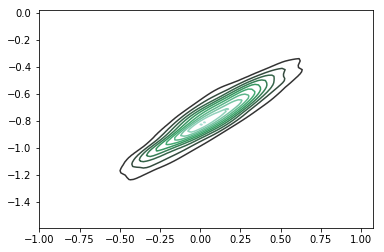

In [31]:
sns.kdeplot(samples[:,1,0,0], samples[:,10,0,1])
plt.show()

In [32]:
t = 18
params[t]

array([[ 0.3209, -0.6453]])

In [33]:
np.mean(samples[:,t], axis=0)

array([[ 0.0956, -0.8461]])